# 3D Fourier Transform
## with an extra gpu array for the 33th complex values

In [1]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import time

In [2]:
%matplotlib inline    

## Loading FFT routines

In [3]:
gridDIM = 64

size = gridDIM*gridDIM*gridDIM

axes0 = 0
axes1 = 1
axes2 = 2

makeC2C = 0
makeR2C = 1
makeC2R = 1

axesSplit_0 = 0
axesSplit_1 = 1
axesSplit_2 = 2

segment_axes0 = 0
segment_axes1 = 0
segment_axes2 = 0

DIR_BASE = "/home/robert/Documents/new1/FFT/code/"

# FAFT
_faft128_3D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_3D_R2C.so' )
_faft128_3D.FAFT128_3D_R2C.restype = int
_faft128_3D.FAFT128_3D_R2C.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_int, ctypes.c_int]

cuda_faft = _faft128_3D.FAFT128_3D_R2C

# Inv FAFT
_ifaft128_3D = ctypes.cdll.LoadLibrary(DIR_BASE+'IFAFT128_3D_C2R.so')
_ifaft128_3D.IFAFT128_3D_C2R.restype = int
_ifaft128_3D.IFAFT128_3D_C2R.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_int, ctypes.c_int]

cuda_ifaft = _ifaft128_3D.IFAFT128_3D_C2R

## Initializing Data

## Gaussian

In [4]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2.  )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p)*np.exp( - p**2*sigma**2/2.  )

 Amplitude x =  5.0
 Amplitude p =  6.0
        
mu_x =  1.5
mu_y =  1.5
mu_z =  1.5
sigma_x =  1.0
sigma_y =  1.0
sigma_z =  1.0
   
n     =  64
dx    =  0.15625
dp    =  0.1875
           standard fft dp =  0.628318530718      
    
delta =  0.0046627424734
    
The Gaussian extends to the numerical error in single precision:
    min =  1.90246820276e-29


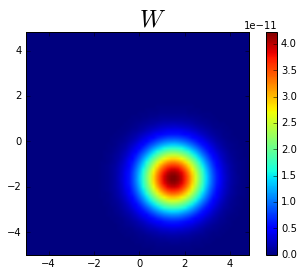

In [5]:
# Gaussian parameters
mu_x = 1.5
sigma_x = 1.

mu_y = 1.5
sigma_y = 1.

mu_z = 1.5
sigma_z = 1.

# Grid parameters
x_amplitude = 5.
p_amplitude = 6.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(gridDIM)  # This is dx in Bailey's paper
dp = 2*p_amplitude/float(gridDIM)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x_range = np.linspace( -x_amplitude, x_amplitude-dx, gridDIM)  
p = np.linspace( -p_amplitude, p_amplitude-dp, gridDIM) 

x = x_range[ np.newaxis, np.newaxis, : ] 
y = x_range[ np.newaxis, :, np.newaxis ] 
z = x_range[ :, np.newaxis, np.newaxis ] 

f =  Gaussian(x,mu_x,sigma_x)*Gaussian(y,mu_y,sigma_y)*Gaussian(z,mu_z,sigma_z)

plt.imshow( f[:, :, 0], extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )

axis_font = {'size':'24'}
plt.text( 0., 5.1, '$W$' , **axis_font)
plt.colorbar()

#plt.ylim(0,0.44)


print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'mu_x = ', mu_x
print 'mu_y = ', mu_y
print 'mu_z = ', mu_z
print 'sigma_x = ', sigma_x
print 'sigma_y = ', sigma_y
print 'sigma_z = ', sigma_z
print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta

print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f)

## $W$ TRANSFORM FROM AXES-0

### After the transfom, f_gpu[:, :32, :] contains real values and f_gpu[:, 32:, :] contains imaginary values. f33_gpu contains the 33th. complex values  

In [6]:
# Matrix for the 33th. complex values

f33 = np.zeros( [64, 1 ,64], dtype = np.complex64 )

In [7]:
# Copy to GPU

if 'f_gpu' in globals():
    f_gpu.gpudata.free()
    
if 'f33_gpu' in globals():
    f33_gpu.gpudata.free()

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f33_gpu = gpuarray.to_gpu( np.ascontiguousarray( f33 , dtype = np.complex64 ) )

### Forward Transform

In [8]:
# Executing FFT

t_init = time.time() 

cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes0, axes0, makeR2C, axesSplit_0 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeC2C, axesSplit_0 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes2, axes2, makeC2C, axesSplit_0 )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  0.221534967422


(0, 5.0)

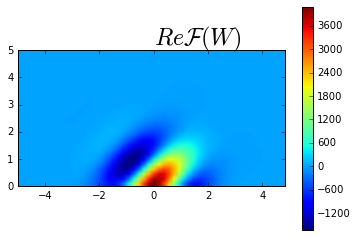

In [9]:
plt.imshow(  np.append( f_gpu.get()[:, :32, :], f33_gpu.get().real, axis=1 )[32,:,:]
           /float(np.sqrt(size)), 
           extent=[-p_amplitude , p_amplitude-dp, 0, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( 0., 5.2, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(0 , x_amplitude)

(0, 5.0)

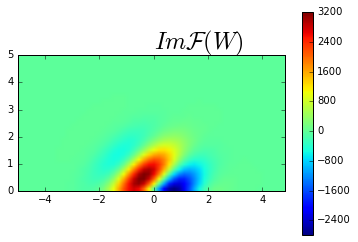

In [10]:
plt.imshow( np.append( f_gpu.get()[:, 32:, :], f33_gpu.get().imag, axis=1 )[32,:,:]
           /float(np.sqrt(size)), 
           extent=[-p_amplitude , p_amplitude-dp, 0, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( 0., 5.2, '$Im \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(0 , x_amplitude)

### Inverse Transform

In [11]:
# Executing iFFT

cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes2, axes2, makeC2C, axesSplit_0 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2C, axesSplit_0 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2R, axesSplit_0 )

1

(-5.0, 4.84375)

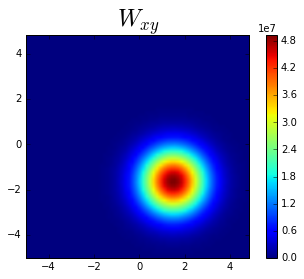

In [12]:
plt.imshow( f_gpu.get()[32,:,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

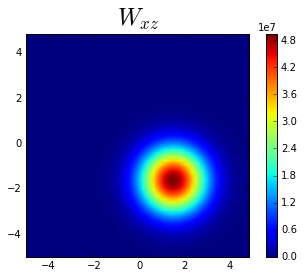

In [13]:
plt.imshow( f_gpu.get()[:,32,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

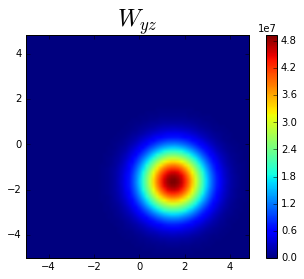

In [14]:
plt.imshow( f_gpu.get()[:,:,32]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{yz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

## $W$ TRANSFORM FROM AXES-1

### After the transfom, f_gpu[:, :, :64] contains real values and f_gpu[:, :, 64:] contains imaginary values. f33_gpu contains the 33th. complex values  

In [15]:
# Matrix for the 33th. complex values

f33 = np.zeros( [64, 64, 1], dtype = np.complex64 )

In [16]:
# One gpu array.

if 'f_gpu' in globals():
    f_gpu.gpudata.free()
    
if 'f33_gpu' in globals():
    f33_gpu.gpudata.free()

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f33_gpu = gpuarray.to_gpu( np.ascontiguousarray( f33 , dtype = np.complex64 ) )

### Forward Transform

In [17]:
# Executing FFT

t_init = time.time() 

cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeR2C, axesSplit_1 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes0, axes0, makeC2C, axesSplit_1 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes2, axes2, makeC2C, axesSplit_1 )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  0.214374065399


(-5.0, 4.84375)

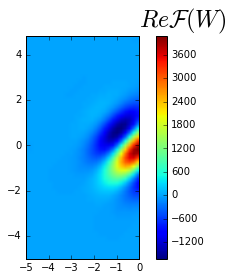

In [18]:
plt.imshow( np.append( f_gpu.get()[:, :, :32], f33_gpu.get().real, axis=2 )[32,:,:]
           /float(np.sqrt(size)), 
           extent=[-p_amplitude , 0, -p_amplitude  , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( 0., 5.2, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-x_amplitude , 0)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

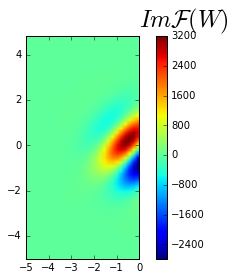

In [19]:
plt.imshow( np.append( f_gpu.get()[:, :, 32:], f33_gpu.get().imag, axis=2 )[32,:,:]
           /float(np.sqrt(size)), 
           extent=[-p_amplitude , 0, -p_amplitude  , p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( 0., 5.2, '$Im \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-x_amplitude , 0)
plt.ylim(-x_amplitude  , x_amplitude-dx)

### Inverse Transform

In [20]:
# Executing iFFT

cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes2, axes2, makeC2C, axesSplit_1 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2C, axesSplit_1 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2R, axesSplit_1 )

1

(-5.0, 4.84375)

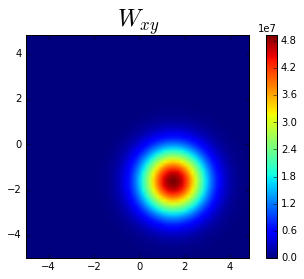

In [21]:
plt.imshow( f_gpu.get()[32,:,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

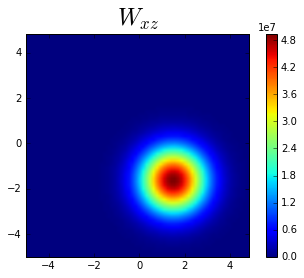

In [22]:
plt.imshow( f_gpu.get()[:,32,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

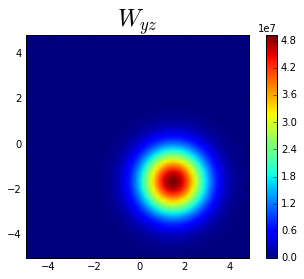

In [23]:
plt.imshow( f_gpu.get()[:,:,32]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{yz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

## $W$ TRANSFORM FROM AXES-2

### After the transfom, f_gpu[:64, :, :] contains real values and f_gpu[64:, :, :] contains imaginary values. f33_gpu contains the 33th. complex values  

In [24]:
# Matrix for the 33th. complex values

f33 = np.zeros( [1, 64, 64], dtype = np.complex64 )

In [25]:
# One gpu array.

if 'f_gpu' in globals():
    f_gpu.gpudata.free()
    
if 'f33_gpu' in globals():
    f33_gpu.gpudata.free()

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f33_gpu = gpuarray.to_gpu( np.ascontiguousarray( f33 , dtype = np.complex64 ) )

### Forward Transform

In [26]:
# Executing FFT

t_init = time.time() 

cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes2, axes2, makeR2C, axesSplit_2 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeC2C, axesSplit_2 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes0, axes0, makeC2C, axesSplit_2 )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  0.2036049366


(0, 4.84375)

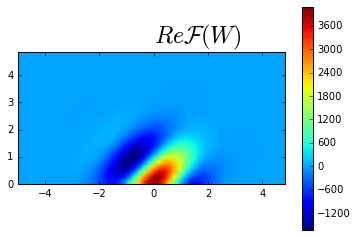

In [27]:
plt.imshow( np.append( f_gpu.get()[:32, :, :], f33_gpu.get().real, axis=0 )[:,:,32]
           /float(np.sqrt(size)), 
           extent=[-p_amplitude , p_amplitude-dp, 0, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( 0., 5.2, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(0 , x_amplitude-dx)

(0, 4.84375)

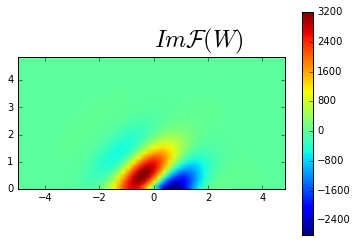

In [28]:
plt.imshow( np.append( f_gpu.get()[32:, :, :], f33_gpu.get().imag, axis=0 )[:,:,32]
           /float(np.sqrt(size)), 
           extent=[-p_amplitude , p_amplitude-dp, 0, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( 0., 5.2, '$Im \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(0 , x_amplitude-dx)

### Inverse Transform

In [29]:
# Executing iFFT

cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2C, axesSplit_2 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2C, axesSplit_2 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes2, axes2, makeC2R, axesSplit_2 )

1

(-5.0, 4.84375)

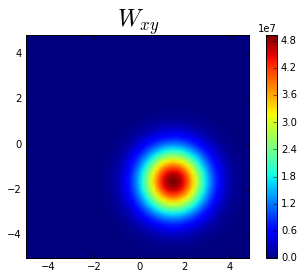

In [30]:
plt.imshow( f_gpu.get()[32,:,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xy}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

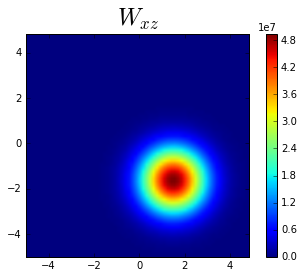

In [31]:
plt.imshow( f_gpu.get()[:,32,:]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{xz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

(-5.0, 4.84375)

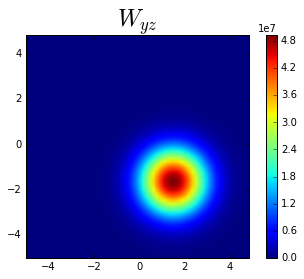

In [32]:
plt.imshow( f_gpu.get()[:,:,32]/float(size) ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] )


plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 5.2, '$W_{yz}$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)